# plot

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great 
import bindome as bd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import pandas as pd 
import numpy as np 

import time

In [3]:
test = "../data/tests/test_data/input/01_random.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"

## Count plot

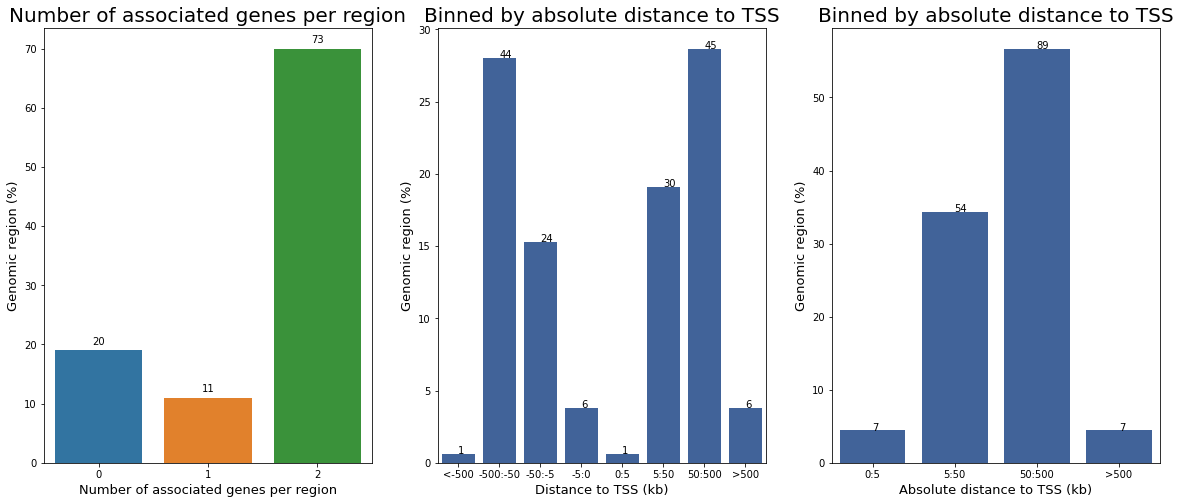

In [4]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
great.pl.graph_nb_asso_per_peaks(test,regdom,ax[0])
great.pl.graph_dist_tss(test,regdom,ax[1])
great.pl.graph_absolute_dist_tss(test,regdom,ax[2])
plt.show()

## Dotplot

### Dotplot of the enrichment 

In [5]:
enrichment = great.tl.GREAT.enrichment(
    test,
    regdom,
    "../data/human/hg38/chr_size.bed", 
    "../data/human/ontologies.csv"
)

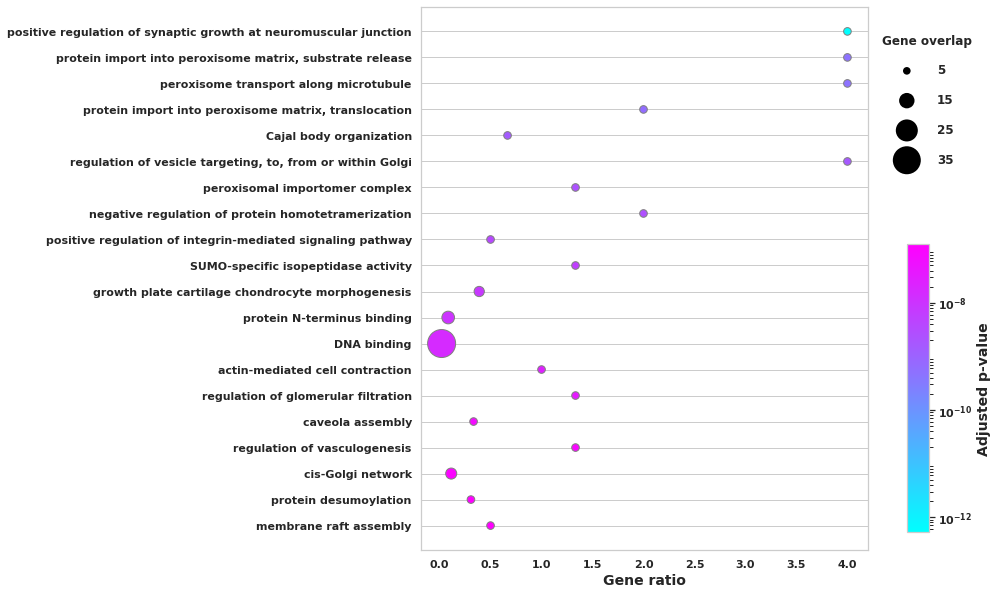

In [7]:
plot = enrichment.rename(columns={"binom_p_value" : "p_value", "go_term":"name"})
plt.figure(figsize=(10,10))
great.pl.plot_enrich(plot)

### Dotoplot of multi-enrichment sample

In [8]:
test = [
    "SRF:Ishikawa,A-673-clone-Asp114,K-562,MCF-7,Hep-G2",
    "MAX:K-562,WA01,HeLa-S3", "BACH1:A-549,GM12878",
    "CDK9:A-375,MM1-S,MV4-11,P493-6,BT-474,HEK293T",
    "GATA1:erythroblast,HUDEP-2,K-562", "IKZF1:K-562,GM12878,HSPC", 
    "SP1:liver,A-375,Hep-G2,HEK293,GM12878,A-549,K-562,HEK293T,WA01",
    "TCF7:Hep-G2,GM12878,K-562", "ZBTB40:MCF-7,Hep-G2,GM12878",
    "AFF1:MV4-11,K-562"
    ]

tmp_df = great.tl.GREAT.enrichment_multiple(
    tests = test, 
    regdom_file="../data/human/hg38/regulatory_domain.bed",
    chr_size_file="../data/human/hg38/chr_size.bed",
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
)

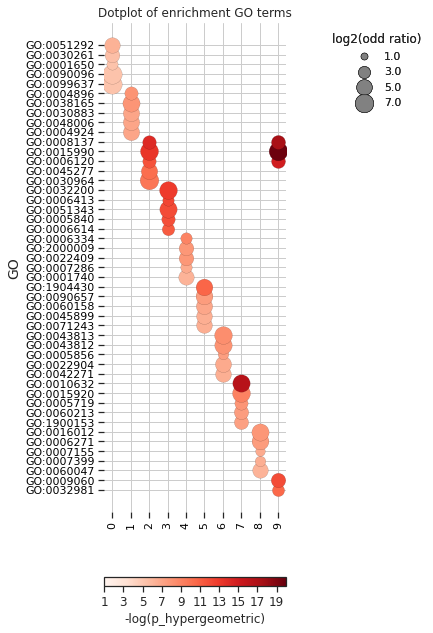

In [70]:
fig = plt.figure(figsize=(15, 12))
p_val,odd_ratio,df = great.pl.dotplot_multi_sample(tmp_df,fig=fig)

<!-- List of terms should be  -->

df['k'] = df['id'].astype(str) + ', ' + df['name'].astype(str).str[:30]

<!-- plt.tight_layout() -->

<!-- log2 odds ratio start with 1 -->

<!-- `great.tl.GREAT.enrichment_multiple` with bindome -->

<!-- show_term_name : bool  -->

<!-- term_name_nchars=None, or integer e.g. 30 -->


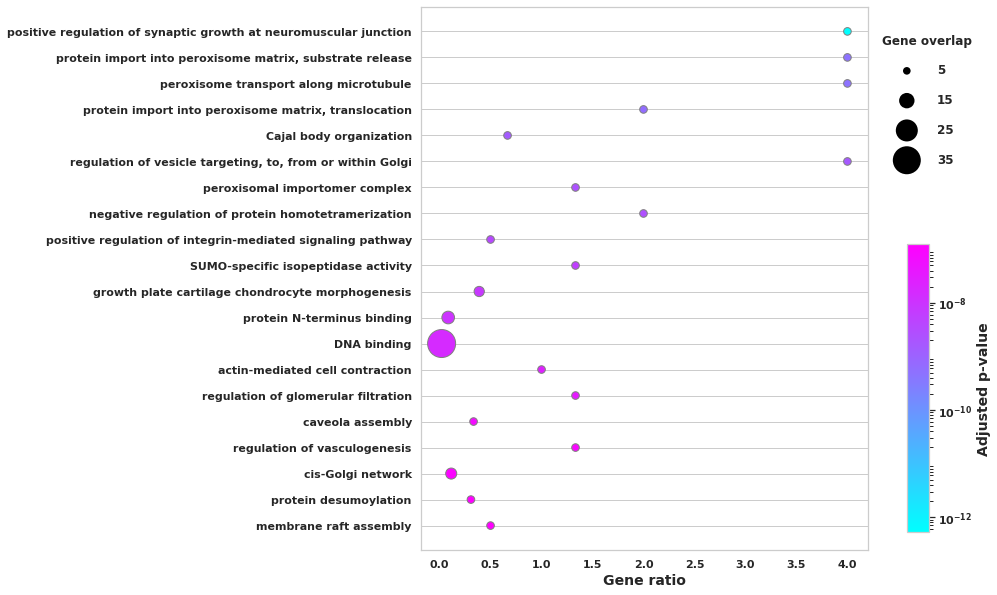

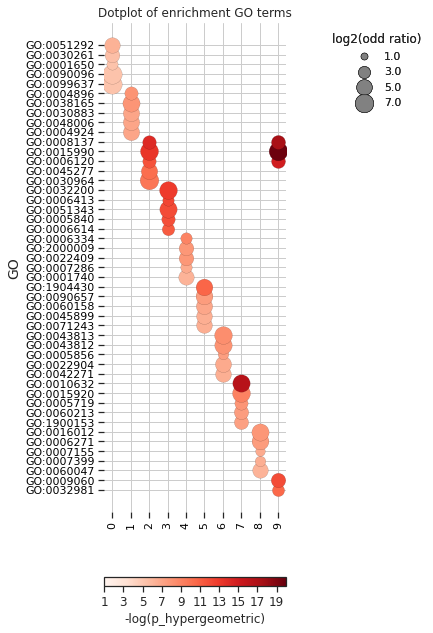

In [79]:
plt.figure(figsize=(10,10))
great.pl.plot_enrich(plot)
fig = plt.figure(figsize=(15,12))
_,_,_ = great.pl.dotplot_multi_sample(tmp_df,fig=fig)

In [68]:
import matplotlib


test = [
    # "SRF:Ishikawa,A-673-clone-Asp114,K-562,MCF-7,Hep-G2", 
    "MAX_K-562,WA01,HeLa-S3", "BACH1_A-549,GM12878",
    # "CDK9:A-375,MM1-S,MV4-11,P493-6,BT-474,HEK293T",
    "GATA1_erythroblast,HUDEP-2,K-562", "IKZF1_K-562,GM12878,HSPC", 
    # "SP1:liver,A-375,Hep-G2,HEK293,GM12878,A-549,K-562,HEK293T,WA01",
    # "TCF7:Hep-G2,GM12878,K-562", "ZBTB40:MCF-7,Hep-G2,GM12878",
    "AFF1_MV4-11,K-562"
    ]

def dotplot(test_data,annpath, n_row:int = 5,fig : matplotlib.figure.Figure or None = None,terms:bool = False ): 
    """
    Dotplot of enrichment GO terms for a given list of example genomic regions.

    Parameters
    ----------
    test_data : list
        List of biosample in SRF to be tested.
    annpath : str
        Path to the annotation repo 
    n_row : int
        Number of rows pick in each dataframe.
    fig : matplotlib.figure.Figure or None 
        Figure to plot the dotplot. 
    
    Returns
    -------
    None.


    """
    min_p,min_od,max_p,max_od = 100,100,0,0
    bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath
    gene_tot={}
    df = pd.DataFrame()

    for i,name in enumerate(test_data) :
        gene_tot[i] = name.split("_")[0]
        res = pd.read_csv(f"../../great_out/{name}.csv",index_col=0)

        res = res.reset_index().rename(columns={"index":"id"})
        res["index"] = [i]*n_row
        frames = [df, res]
        df = pd.concat(frames)

        print(f"done ... {i}")

    df["hypergeom_p_value"] = -np.log(df["hypergeom_p_value"])
    df["hypergeometric_fold_enrichment"] = np.log2(df["hypergeometric_fold_enrichment"])
    dup = df[df.duplicated("id")==True]        
    duplicate = dup.drop(columns=["go_term","binom_p_value","binom_fold_enrichment","intersection_size","recall"]).to_dict()
    df = df.drop_duplicates("id")
    p_val = df.pivot("id","index","hypergeom_p_value").fillna(1).reindex(df["id"])
    odd_ratio = df.pivot("id","index","hypergeometric_fold_enrichment").fillna(0).reindex(df["id"])
    
    for i,name in enumerate(duplicate["id"].values()): 
        p_val[duplicate["index"][i]][name] = duplicate["hypergeom_p_value"][i]
        odd_ratio[duplicate["index"][i]][name] = duplicate["hypergeometric_fold_enrichment"][i]
    
    p_val.rename(columns=gene_tot,inplace=True)
    odd_ratio.rename(columns=gene_tot,inplace=True)

    if terms : 
        go_n = []
        # go_n = df.drop(columns = ["binom_p_value","binom_fold_enrichment","hypergeom_p_value","hypergeometric_fold_enrichment","intersection_size","recall","index"]).to_dict()
        for i in range(df.shape[0]) : 
            curr = df.iloc[i]
            go_n.append(curr["id"] + " " + curr["go_term"][:30])
        # return go_n
        p_val["test"] = go_n
        odd_ratio["test"] = go_n

        p_val = p_val.set_index("test")
        odd_ratio = odd_ratio.set_index("test")

    for i in p_val.columns : 
        if min_p > p_val[i].min() : 
            min_p = p_val[i].min()
        if max_p < p_val[i].max() : 
            max_p = p_val[i].max()

    for i in odd_ratio.columns : 
        if min_od > odd_ratio[i].min() : 
            min_od = odd_ratio[i].min()
        if max_od < odd_ratio[i].max() : 
            max_od = odd_ratio[i].max()
    
    max_p = int(round(max_p))
    max_od = int(round(max_od))
    min_p = int(round(min_p))
    min_od = int(round(min_od))
    
    plt.rcParams.update({"font.size": 14, "font.weight": "normal"})
    plt.tight_layout(pad=0.1,h_pad=0.1,w_pad=0.1)
    
    make_bubble_heatmap(
        p_val,odd_ratio,quantAmplifier = 7,circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],palette_id="Reds",
        ylab='GO',xlab='', tickscolorbar=[int(i) for i in range(round(min_p),round(max_p)+1)],vmin=min_p,vmax=max_p, cbar_label='-log(p_hypergeometric)',
        marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",sig_line_width=0.1,
        circles_legend_title="log2(odd ratio)" ,cbar_fmt_ticks = "%.0f",
        fig=fig
        )
    
    return p_val,odd_ratio

done ... 0
done ... 1
done ... 2
done ... 3
done ... 4


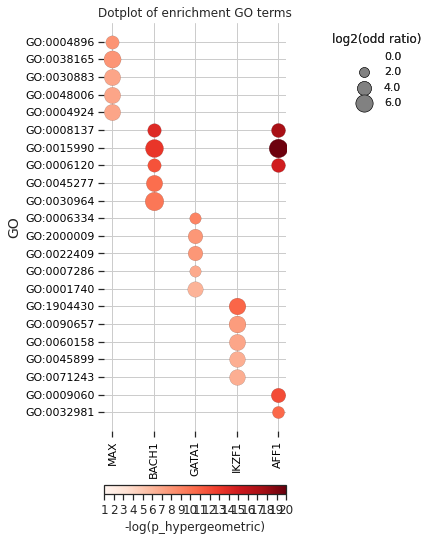

In [73]:
fig = plt.figure(figsize=(15, 10))
p_val,odd_ratio = dotplot(test,annpath="../../annotation/",fig=fig)